In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

In [4]:
df = pd.read_csv("/Users/deepthiramesh/Documents/Extra Projects/Supply chain delay analysis/Dataset/dynamic_supply_chain_logistics_dataset_with_country.csv")

In [5]:
# Step 3: Data Cleaning & Parsing with synthetic delivery dates
num_rows = len(df)
base_dates = pd.date_range(start='2011-01-01', periods=1825, freq='D')
repeated_dates = np.tile(base_dates, int(np.ceil(num_rows / len(base_dates))))[:num_rows]

df['Scheduled Delivery Date'] = repeated_dates
df['Delivered to Client Date'] = df['Scheduled Delivery Date'] + pd.to_timedelta(df['delivery_time_deviation'].fillna(0), unit='D')
df['delay_days'] = (df['Delivered to Client Date'] - df['Scheduled Delivery Date']).dt.days
df = df[df['delay_days'].notnull()]

In [6]:
# Step 4: Delay Analysis
df['Route'] = df['supplier_country'] + " → Destination"
df['Delivery Hour'] = df['Delivered to Client Date'].dt.hour
df['Delivery Day'] = df['Delivered to Client Date'].dt.day_name()

In [7]:
# Step 5: Delay Summary
delay_summary = df.groupby('Route')['delay_days'].agg(['mean', 'std', 'count']).reset_index()
carrier_delay = df.groupby('supplier_id')['delay_days'].mean().sort_values(ascending=False)

In [9]:
# Step 6: Modeling (Random Forest)
model_df = df[['delay_days', 'risk_classification', 'supplier_id', 'product_id', 'historical_demand']].dropna()
le = LabelEncoder()
for col in ['risk_classification', 'supplier_id', 'product_id']:
    model_df[col] = le.fit_transform(model_df[col])

X = model_df.drop('delay_days', axis=1)
y = model_df['delay_days']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

rf = RandomForestRegressor(n_estimators=30, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

R² Score: 0.8662386852346627
RMSE: 1.4885299086441581


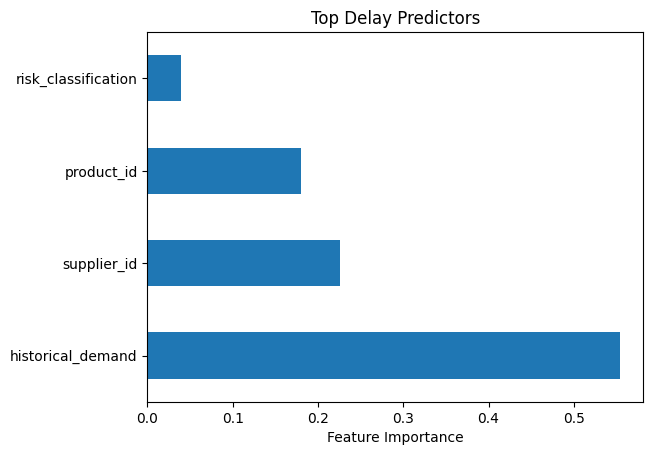

In [11]:
# Delay Prediction Visualization
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='barh')
plt.title("Top Delay Predictors")
plt.xlabel("Feature Importance")
plt.show()

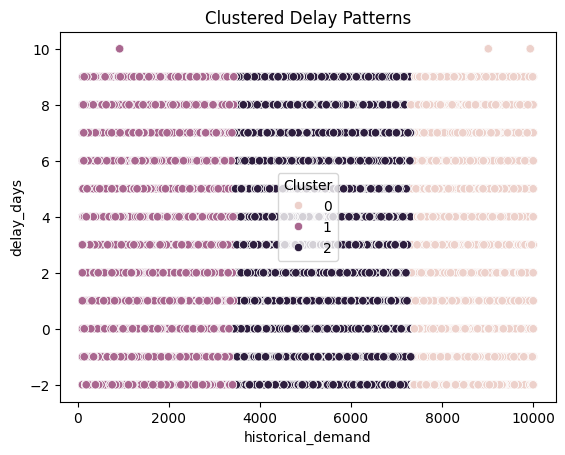

In [12]:
# Step 7: Clustering (KMeans)
clust_data = df[['historical_demand', 'delay_days']].dropna()
kmeans = KMeans(n_clusters=3, random_state=0).fit(clust_data)
clust_data['Cluster'] = kmeans.labels_

sns.scatterplot(data=clust_data, x='historical_demand', y='delay_days', hue='Cluster')
plt.title('Clustered Delay Patterns')
plt.show()

In [15]:
clust_data = df[['historical_demand', 'delay_days']].dropna()
kmeans = KMeans(n_clusters=3).fit(clust_data)


In [13]:
# Step 8: Impact Analysis
sla_threshold = 7
df['SLA_Breached'] = df['delay_days'] > sla_threshold
sla_before = df[df['Scheduled Delivery Date'] < '2013-01-01']['SLA_Breached'].mean()
sla_after = df[df['Scheduled Delivery Date'] >= '2013-01-01']['SLA_Breached'].mean()

print(f"SLA Breach Rate Before 2013: {sla_before:.2%}")
print(f"SLA Breach Rate After 2013: {sla_after:.2%}")

SLA Breach Rate Before 2013: 37.48%
SLA Breach Rate After 2013: 37.28%


In [17]:
#Root Cause SLA Analysis

# Generate SLA_Breached column (if not already done)
sla_threshold = 7
df['SLA_Breached'] = df['delay_days'] > sla_threshold

#Group by Supplier ID — Top 10 suppliers with highest SLA breach rates
sla_breaches_by_supplier = (
    df.groupby('supplier_id')['SLA_Breached']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# Group by Risk Classification
sla_breaches_by_risk = (
    df.groupby('risk_classification')['SLA_Breached']
    .mean()
    .sort_values(ascending=False)
)

#Results
print("🔧 Top 10 Suppliers by SLA Breach Rate:")
print(sla_breaches_by_supplier)

print("\n⚠️ SLA Breach Rate by Risk Classification:")
print(sla_breaches_by_risk)


🔧 Top 10 Suppliers by SLA Breach Rate:
supplier_id
P0832_S2    0.727273
P0832_S3    0.727273
P0832_S4    0.727273
P0832_S1    0.727273
P0133_S1    0.666667
P0133_S2    0.666667
P0442_S2    0.633333
P0442_S3    0.633333
P0442_S4    0.633333
P0442_S5    0.633333
Name: SLA_Breached, dtype: float64

⚠️ SLA Breach Rate by Risk Classification:
risk_classification
Moderate Risk    0.374684
High Risk        0.374419
Low Risk         0.365796
Name: SLA_Breached, dtype: float64


In [14]:
# Delay cost estimation
COST_PER_DELAY_DAY = 50
df['delay_cost'] = df['delay_days'].clip(lower=0) * COST_PER_DELAY_DAY
total_cost = df['delay_cost'].sum()
print(f"Estimated Total Delay Cost: ${total_cost:,.2f}")

Estimated Total Delay Cost: $27,817,700.00
